In [1]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StandardScaler, VectorAssembler
from pyspark.sql import SparkSession, functions as F, types, Window
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import pandas as pd
import folium as fol
import haversine as hs

#import org.apache.log4j.{Level, Logger}
#from scipy.spatial import distance
#from pyspark import sql

Iniciamos la sesion spark

In [2]:
sparkConf = SparkSession\
        .builder\
        .appName("Spark ML Clustering")\
        .getOrCreate()

Quitamos los mensajes de log de las ejecuciones de celdas

In [3]:
#logger = sparkConf._jvm.org.apache.log4j
#logger.LogManager.getLogger("org").setLevel(logger.Level.WARN)
#logger.LogManager.getLogger("org").setLevel(logger.Level.INFO)

 

Cargamos los datos del archivo csv

In [3]:
    # Loads data
    chicago_raw= sparkConf\
        .read\
        .format("csv")\
        .option("header", "true")\
        .load("..\Datasets\crimes.csv")
        #.load(sys.argv[1])

Mostramos el dataset

In [4]:
chicago_raw=chicago_raw.select("ID","Date","Primary Type","Arrest","Domestic","District","Latitude","Longitude")

Ahora con Timestamp lo que tenemos en la columna de fecha es el numero de milisegundos desde el 1 de enero de 1970

In [5]:
chicago_raw = chicago_raw.withColumn("Date", F.to_timestamp(F.unix_timestamp("Date", "M/dd/yyyy hh:mm:ss a").cast("timestamp")))

Lo pasamos a tipo fecha

In [6]:
chicago_raw = chicago_raw.withColumn("Date", F.to_date(F.unix_timestamp("Date", "M/dd/yyyy hh:mm:ss a").cast("timestamp")))

In [9]:
chicago_raw.show(10)

+--------+----------+------------------+------+--------+--------+------------+-------------+
|      ID|      Date|      Primary Type|Arrest|Domestic|District|    Latitude|    Longitude|
+--------+----------+------------------+------+--------+--------+------------+-------------+
|10224738|2015-09-05|           BATTERY| false|    true|     009|41.815117282|-87.669999562|
|10224739|2015-09-04|             THEFT| false|   false|     015|41.895080471|-87.765400451|
|11646166|2018-09-01|             THEFT| false|    true|     006|        null|         null|
|10224740|2015-09-05|         NARCOTICS|  true|   false|     014|41.937405765|-87.716649687|
|10224741|2015-09-05|           ASSAULT| false|    true|     015|41.881903443|-87.755121152|
|10224742|2015-09-05|          BURGLARY| false|   false|     006|41.744378879|-87.658430635|
|10224743|2015-09-04|          BURGLARY| false|   false|     014|41.914635603|-87.681630909|
|10224744|2015-09-05|             THEFT|  true|   false|     010|41.85

Quitamos las filas con valores nulos del dataset

In [7]:
chicago_raw.count()

7433155

In [8]:
chicago_raw=chicago_raw.na.drop()

In [9]:
chicago_raw.count()

7358359

Exploramos la forma y el tamaño del dataframe con el que vamos a trabajar

In [11]:
registro_outlier = chicago_raw.filter(chicago_raw['Latitude'] == 36.619446395)

In [14]:
registro_outlier.show()

+--------+----------+--------------------+------+--------+--------+------------+-------------+
|      ID|      Date|        Primary Type|Arrest|Domestic|District|    Latitude|    Longitude|
+--------+----------+--------------------+------+--------+--------+------------+-------------+
|    1051|2001-09-03|            HOMICIDE|  true|   false|     010|36.619446395|-91.686565684|
|    1206|2001-11-11|            HOMICIDE| false|   false|     011|36.619446395|-91.686565684|
| 6063108|2008-01-30|             ROBBERY| false|   false|     009|36.619446395|-91.686565684|
| 6125233|2008-02-15|  DECEPTIVE PRACTICE| false|   false|     016|36.619446395|-91.686565684|
| 6200282|2008-04-12|               THEFT| false|   false|     014|36.619446395|-91.686565684|
|11732417|2019-06-23|             BATTERY| false|    true|     011|36.619446395|-91.686565684|
| 6169464|2008-03-26| CRIM SEXUAL ASSAULT| false|   false|     014|36.619446395|-91.686565684|
| 6229358|2008-05-04|   WEAPONS VIOLATION|  true| 

In [12]:
chicago_raw = chicago_raw.filter((chicago_raw['Latitude'] <= 42.221944) | 
                                    (chicago_raw['Longitude'] >= -87.967778) | 
                                    (chicago_raw['Latitude'] >= 41.541944) | 
                                    (chicago_raw['Longitude'] <= -87.287778))

In [13]:
chicago_raw.count()

7358243

Cambiamos el tipo de las columnas Latitude y Longitude a double y las de Arrest y Domestic que son booleanas a entero 

In [18]:
chicago_raw = chicago_raw.withColumn("Latitude", chicago_raw["Latitude"].cast(types.DoubleType()))
chicago_raw = chicago_raw.withColumn("Longitude", chicago_raw["Longitude"].cast(types.DoubleType()))
chicago_raw = chicago_raw.withColumn("Arrest", chicago_raw["Arrest"].cast(types.BooleanType()))
chicago_raw = chicago_raw.withColumn("Domestic", chicago_raw["Domestic"].cast(types.BooleanType()))
chicago_raw = chicago_raw.withColumn("Arrest", chicago_raw["Arrest"].cast(types.IntegerType()))
chicago_raw = chicago_raw.withColumn("Domestic", chicago_raw["Domestic"].cast(types.IntegerType()))
chicago_raw = chicago_raw.withColumn("District", chicago_raw["District"].cast(types.IntegerType()))
chicago_raw.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Arrest: integer (nullable = true)
 |-- Domestic: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [19]:
assemble=VectorAssembler(inputCols=[

 'Latitude',
 'Longitude'], outputCol='features')

assembled_data=assemble.transform(chicago_raw)

#assembled_data.show(2)

In [20]:
# Entrenamos el modelo Kmeans
kmeans = KMeans(featuresCol='features').setK(15).setSeed(1)
model = kmeans.fit(assembled_data)

# Hacemos las predicciones
predictions = model.transform(assembled_data)

# Evaluamos el cluster
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Mostramos los resultados
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
     print(center)

Silhouette with squared euclidean distance = 0.5541350729682784
Cluster Centers: 
[ 41.78271802 -87.72886713]
[ 41.99125492 -87.68393068]
[ 41.8912409  -87.75322945]
[ 41.74007018 -87.56384642]
[ 41.86296447 -87.7070921 ]
[ 41.9760997  -87.85491963]
[ 41.82045956 -87.62234363]
[ 41.68911972 -87.62759562]
[ 41.78623041 -87.66947071]
[ 41.76531267 -87.60885543]
[ 41.94371185 -87.65816369]
[ 41.73796693 -87.65701981]
[ 41.91482353 -87.70769658]
[ 41.94793551 -87.76406725]
[ 41.88673599 -87.63975014]


Exportamos a csv los centroides, el orden en el que se muestran es el cluster al que representa 

In [21]:
df = pd.DataFrame(columns=['Latitude_C', 'Longitude_C'])
for center in centers:
    df.loc[len(df)] = [center[0], center[1]]

df.to_csv('..\Datasets\centroides.csv', index_label = 'Cluster')

Cargamos los centroides en un dataframe

In [22]:
    centroides= sparkConf\
        .read\
        .format("csv")\
        .option("header", "true")\
        .load("..\Datasets\centroides.csv")

In [104]:
#Tenemos que estudiar como se está calculando el evaluador, si es mejor bajo o alto y utilizar la distancia a Manhattan
silhouette_score=[]
evaluator = ClusteringEvaluator()
prediction_max = None
centroids_max = None
score_max = 0


for i in range(10,21):
    
    KMeans_algo=KMeans(featuresCol='features', k=i)
    
    KMeans_fit=KMeans_algo.fit(assembled_data)    
    output=KMeans_fit.transform(assembled_data) 
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    if(score > score_max):
        prediction_max = output
        centroids_max = KMeans_fit.clusterCenters()
        score_max = score
    
    print("Silhouette Score:",score,"i=",i)

Silhouette Score: 0.49205955554557795 i= 10
Silhouette Score: 0.5444808623932896 i= 11
Silhouette Score: 0.546314016094265 i= 12
Silhouette Score: 0.5404772346108718 i= 13
Silhouette Score: 0.5470369759309137 i= 14
Silhouette Score: 0.5562680960051609 i= 15
Silhouette Score: 0.5526647778686206 i= 16
Silhouette Score: 0.5413358616626154 i= 17
Silhouette Score: 0.5440012553306598 i= 18
Silhouette Score: 0.5449947219115913 i= 19
Silhouette Score: 0.5407585808891094 i= 20


Text(0, 0.5, 'silhoutte')

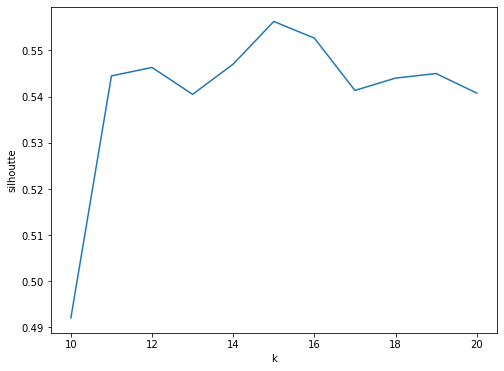

In [105]:
#Visualizing the silhouette scores in a plot

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(10,21),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('silhoutte')

In [57]:
#Tenemos que estudiar como se está calculando el evaluador, si es mejor bajo o alto y utilizar la distancia a Manhattan
silhouette_score30=[]
evaluator30 = ClusteringEvaluator()
prediction_max30 = None
centroids_max30 = None
score_max30 = 0


for i in range(21,31):
    
    KMeans_algo30=KMeans(featuresCol='features', k=i)
    
    KMeans_fit30=KMeans_algo30.fit(assembled_data)    
    output30=KMeans_fit30.transform(assembled_data) 
    
    score30=evaluator30.evaluate(output30)
    
    silhouette_score30.append(score30)
    
    if(score30 > score_max30):
        prediction_max30 = output30
        centroids_max30 = KMeans_fit30.clusterCenters()
        score_max30 = score30
    
    print("Silhouette Score:",score30,"i=",i)

Silhouette Score: 0.5439370142322393 i= 21
Silhouette Score: 0.5400081063973012 i= 22
Silhouette Score: 0.5592254558122508 i= 23
Silhouette Score: 0.5495497056030424 i= 24
Silhouette Score: 0.5365775679079144 i= 25
Silhouette Score: 0.5507086840398722 i= 26
Silhouette Score: 0.5392060407883819 i= 27
Silhouette Score: 0.5370101120449307 i= 28
Silhouette Score: 0.5385754645911116 i= 29
Silhouette Score: 0.5513085359937699 i= 30


Text(0, 0.5, 'silhoutte')

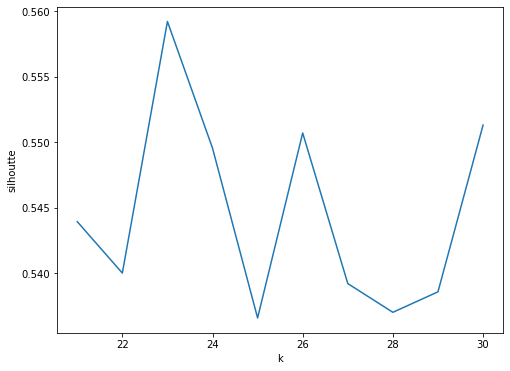

In [59]:
#Visualizing the silhouette scores in a plot

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(21,31),silhouette_score30)
ax.set_xlabel('k')
ax.set_ylabel('silhoutte')

In [23]:
predictions_processed1 = predictions[['ID','Primary Type','Arrest','Domestic','District','prediction','Latitude','Longitude']]

In [24]:
predictions_processed1 = predictions_processed1.withColumnRenamed("prediction","Cluster")

In [25]:
predictions_processed1 =  predictions_processed1.join(centroides, on = 'Cluster')

In [26]:
predictions_processed1.repartition(1)\
    .write.format("csv")\
    .mode("overwrite")\
    .option("header", "true")\
    .save("..\Datasets\Resultados")

IMPORTAMOS EL CSV PARA NO TENER QUE REALIZAR EL CLUSTERING CADA VEZ QUE VOLVEMOS A TRABAJAR

In [27]:
    # Loads data
    chicago_procesed= sparkConf\
        .read\
        .format("csv")\
        .option("header", "true")\
        .load("..\Datasets\procesado.csv")

In [28]:
chicago_procesed.count()

7358243

Agregamos el dataframe para trabajar con algo más ligero y manejable. Esto nos permite un desarrollo más ágil y menor tiempo de computo de cada celda posterior.

In [29]:
chicago_procesed_agg_KPI = chicago_procesed.groupBy('Primary Type','Arrest','Domestic','District','Cluster') \
.count() \
.withColumnRenamed("count","num_crimes")

In [30]:
chicago_procesed_agg_KPI.repartition(1)\
    .write.format("csv")\
    .mode("overwrite")\
    .option("header", "true")\
    .save("..\Datasets\KPI")

In [31]:
    # Loads data
    chicago_procesed_agg_KPI= sparkConf\
        .read\
        .format("csv")\
        .option("header", "true")\
        .load("..\Datasets\df_kpi.csv")

In [35]:
chicago_procesed_agg_KPI = chicago_procesed_agg_KPI.withColumn("num_crimes", chicago_procesed_agg_KPI["num_crimes"].cast(types.IntegerType()))

A continuación se valida los resultados del dataframe agregado con el que se trabajará

In [32]:
chicago_procesed_agg_KPI.show(10)

+--------------------+------+--------+--------+-------+----------+
|        Primary Type|Arrest|Domestic|District|Cluster|num_crimes|
+--------------------+------+--------+--------+-------+----------+
|   CRIMINAL TRESPASS|     1|       0|       1|     14|     10963|
|             BATTERY|     1|       0|      17|     13|      1762|
|             ROBBERY|     0|       0|      24|      1|      7543|
|            BURGLARY|     0|       0|      15|      2|      9843|
|             ROBBERY|     0|       0|      25|     13|      4501|
|             ASSAULT|     0|       0|       4|      9|      1364|
|     CRIMINAL DAMAGE|     0|       1|      11|      2|      1434|
|INTERFERENCE WITH...|     1|       0|      25|     12|       345|
|INTERFERENCE WITH...|     1|       0|      22|      7|       212|
|               THEFT|     0|       0|       7|      6|       570|
+--------------------+------+--------+--------+-------+----------+
only showing top 10 rows



In [33]:
chicago_procesed_agg_KPI.count()

5704

In [36]:
chicago_procesed_agg_KPI_2 = chicago_procesed_agg_KPI.groupBy('District','Cluster').sum('num_crimes').withColumnRenamed("sum(num_crimes)","num_crimes")

In [37]:
chicago_procesed_agg_KPI_2.show(10)

+--------+-------+----------+
|District|Cluster|num_crimes|
+--------+-------+----------+
|      31|      3|        13|
|      31|      7|         3|
|       9|      4|     28413|
|      31|      1|        27|
|      12|      7|         1|
|      20|     10|     23126|
|      15|      0|         1|
|      31|     11|        19|
|       7|      1|         1|
|      31|     13|         6|
+--------+-------+----------+
only showing top 10 rows



In [38]:
chicago_procesed_agg_KPI_2.filter(chicago_procesed_agg_KPI_2.District  == "31")\
    .show(truncate=False)

+--------+-------+----------+
|District|Cluster|num_crimes|
+--------+-------+----------+
|31      |3      |13        |
|31      |7      |3         |
|31      |1      |27        |
|31      |11     |19        |
|31      |13     |6         |
|31      |14     |1         |
|31      |12     |3         |
|31      |8      |7         |
|31      |9      |2         |
|31      |5      |125       |
|31      |2      |9         |
|31      |10     |2         |
|31      |4      |1         |
+--------+-------+----------+



Empezamos a dibujar los poligonos

In [39]:
poligonos=chicago_procesed[['Cluster','Latitude', 'Longitude','Latitude_C', 'Longitude_C']]
#poligonos.show(10)

In [40]:
poligonos.count()

7358243

In [41]:
poligonos_processed = poligonos.groupBy('Cluster','Latitude', 'Longitude','Latitude_C', 'Longitude_C') \
.count() \
.withColumnRenamed("count","num_crimes")

#poligonos_processed.show(2)

In [42]:
poligonos_processed.count()

880734

Usamos el dataframe de centroides y el de poligonos procesados y recorremos por cada cluster

In [43]:
poligonos_processed = poligonos_processed.withColumn("Latitude", poligonos_processed["Latitude"].cast(types.DoubleType()))
poligonos_processed = poligonos_processed.withColumn("Longitude", poligonos_processed["Longitude"].cast(types.DoubleType()))
poligonos_processed = poligonos_processed.withColumn("Latitude_C", poligonos_processed["Latitude_C"].cast(types.DoubleType()))
poligonos_processed = poligonos_processed.withColumn("Longitude_C", poligonos_processed["Longitude_C"].cast(types.DoubleType()))
poligonos_processed = poligonos_processed.withColumn("Cluster", poligonos_processed["Cluster"].cast(types.IntegerType()))

In [44]:
assemble2=VectorAssembler(inputCols=[

 'Latitude',
 'Longitude'], outputCol='features')

assembled_data2=assemble2.transform(poligonos_processed)

#assembled_data2.show(2)

In [45]:
assemble3=VectorAssembler(inputCols=[

 'Latitude_C',
 'Longitude_C'], outputCol='features_C')

assembled_data3=assemble3.transform(assembled_data2)

#assembled_data3.show(2)

In [46]:
assembled_data3.count()

880734

In [47]:
distance_udf = F.udf(lambda x,y: float(hs.haversine(x, y,unit=hs.Unit.METERS)), types.FloatType())

In [48]:
poligonos_processed = assembled_data3.withColumn('Distances', distance_udf(F.col('features'),F.col('features_C')))

In [49]:
poligonos_processed = poligonos_processed[['Cluster','Latitude_C', 'Longitude_C','Distances','Latitude', 'Longitude']]

In [80]:
Circulos = poligonos_processed.groupby('Cluster','Latitude_C','Longitude_C').agg({"Distances":"avg"})\
    .withColumnRenamed("avg(Distances)","Distances")

In [84]:
Circulos.repartition(1)\
    .write.format("csv")\
    .mode("overwrite")\
    .option("header", "true")\
    .save("..\Datasets\Circulos")

In [71]:
poligonos_processed2=poligonos_processed[['Distances','Latitude', 'Longitude']]

In [81]:
Circulos2 = Circulos.join(poligonos_processed2, on = 'Distances')

In [78]:
#Con 6 Cluster tenemos:
Circulos2.show()

+---------+-------+----------+-----------+--------+---------+
|Distances|Cluster|Latitude_C|Longitude_C|Latitude|Longitude|
+---------+-------+----------+-----------+--------+---------+
+---------+-------+----------+-----------+--------+---------+



In [82]:
Circulos2.count()

0

In [83]:
Circulos2.columns

['Distances', 'Cluster', 'Latitude_C', 'Longitude_C', 'Latitude', 'Longitude']

In [68]:
chicago_raw.withColumn("datetime", F.col("Date").cast("timestamp"))\
    .groupBy().agg(F.min("datetime")).show()

+-------------------+
|      min(datetime)|
+-------------------+
|2001-01-01 00:00:00|
+-------------------+



In [54]:
prueba = chicago_procesed.groupBy('Cluster','Latitude','Longitude') \
.count() \
.withColumnRenamed("count","num_crimes")